<a href="https://colab.research.google.com/github/prabhupad26/rnn-sandbox/blob/main/RNN%2C_GRU%2C_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Difference between a RNN and traditional feed-forward neural network:
The main difference is in how the input is consuming the data to produce the results.

Traditional feed-forward neural networks take in a fixed amount of input data all at the same time and produce a fixed amount of output each time. On the other hand, RNNs do not consume all the input data at once. Instead, they take them in one at a time and in a sequence. At each step, the RNN does a series of calculations before producing an output. The output, known as the hidden state, is then combined with the next input in the sequence to produce another output. This process continues until the model is programmed to finish or the input sequence ends.

There are several modes of output in RNNs depending upon the use case 


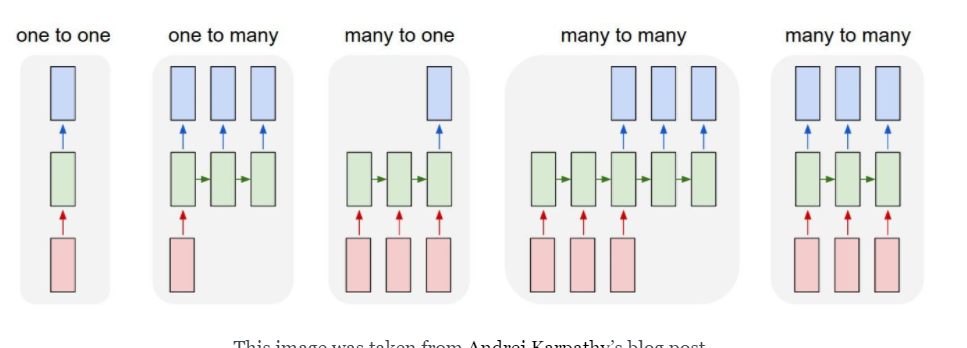



Deep Recurrent neural network (T+RNN with > 1 hidden layer):

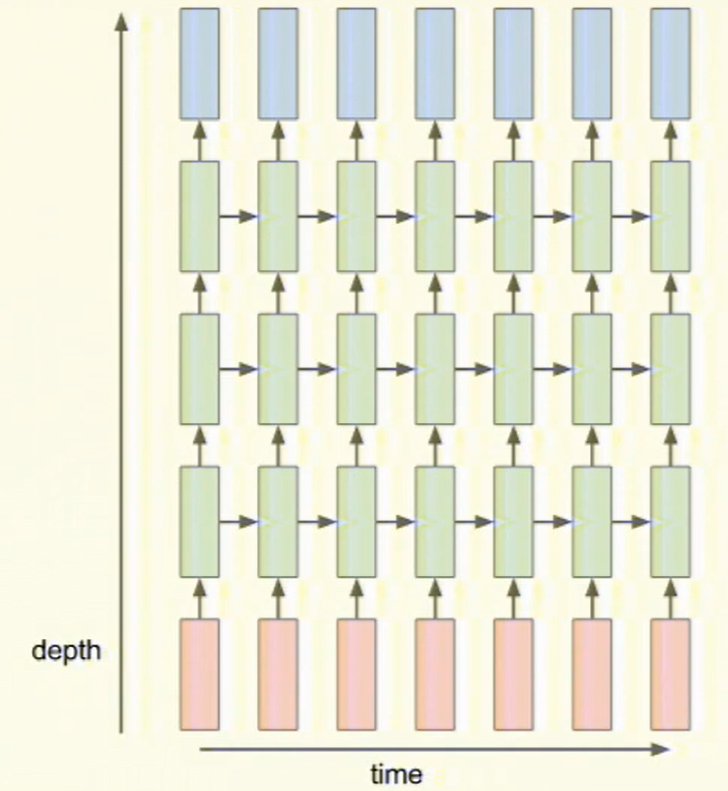

In [2]:
  import torch
 from torch import nn
 import numpy as np

#### Creating vocabulary dictionaries

In [3]:
text = ['i am sam', 'i am building an ML app', 'this is so exciting']
chars = set(''.join(text))
int2char = dict(enumerate(chars))
char2int = {char: ind for ind, char in int2char.items()}

#### Preprocessing the input text

In [4]:
max_len = len(max(text, key = len))
for i in range(len(text)):
  while len(text[i]) < max_len:
    text[i] += ' '

#### Creating input sequences and target sequences

In [5]:
input_seq = []
target_seq = []

for i in range(len(text)):
  input_seq.append(text[i][:-1])
  target_seq.append(text[i][1:])
  print("Input Sequence: {}\nTarget Sequence:{}".format(input_seq[i], target_seq[i]))

Input Sequence: i am sam              
Target Sequence: am sam               
Input Sequence: i am building an ML ap
Target Sequence: am building an ML app
Input Sequence: this is so exciting   
Target Sequence:his is so exciting    


#### One-hot encoding

In [5]:
# Converting chars to int
for i in range(len(text)):
  input_seq[i] = [char2int[char] for char in input_seq[i]]
  target_seq[i] = [char2int[char] for char in target_seq[i]]

dict_size = len(char2int)
seq_len = max_len - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
  """
  Creates a zero matrix in numpy with dimensions of - batch_size x seq_len x dict_size
  """
  features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
  
  for i in range(batch_size):
    for u in range(seq_len):
      features[i, u, sequence[i][u]] = 1
  return features

input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
input_seq.shape

(3, 22, 20)

In [6]:
# Converting to torch tensors
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)

In [7]:
is_cuda = torch.cuda.is_available()
if is_cuda:
  device = torch.device('cuda')
  print("GPU is available")
else:
  device = torch.device("cpu")
  print("GPU is not available, CPU Used")

GPU is not available, CPU Used


#### Define the RNN model

In [1]:
class Model(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(Model, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x):
    batch_size = x.size(0)
    #Initialization for the first input to the RNN network
    hidden = self.init_hidden(batch_size)
    #Forward pass
    out, hidden = self.rnn(x, hidden)
    #Fitting the output to fully connected layer
    out = out.contiguous().view(-1, self.hidden_dim)
    #Passing the output to fully connected layer
    out = self.fc(out)
    return out, hidden

  def init_hidden(self, hidden_size):
    hidden = torch.zeros(self.n_layers, hidden_size, self.hidden_dim)
    return hidden

NameError: ignored

In [9]:
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
model.to(device)

# Define hyperparameters
n_epochs = 100
lr = 0.01

# Define loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### Train the model

In [10]:
for epoch in range(1, n_epochs + 1):
  optimizer.zero_grad()
  input_seq.to(device)
  output, hidden = model(input_seq)
  loss = criterion(output, target_seq.view(-1).long())
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
    print(f"Epoch: {epoch}/{n_epochs}", end = ' ')
    print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100 Loss: 2.3035
Epoch: 20/100 Loss: 2.0890
Epoch: 30/100 Loss: 1.8050
Epoch: 40/100 Loss: 1.4736
Epoch: 50/100 Loss: 1.1377
Epoch: 60/100 Loss: 0.8434
Epoch: 70/100 Loss: 0.6052
Epoch: 80/100 Loss: 0.4267
Epoch: 90/100 Loss: 0.3047
Epoch: 100/100 Loss: 0.2245


Testing the model

In [11]:
def predict(model, character):
  character = np.array([[char2int[c] for c in character]])
  character = one_hot_encode(character, dict_size, character.shape[1], 1)
  character = torch.from_numpy(character)
  character.to(device)
  out, hidden = model(character)
  prob = nn.functional.softmax(out[-1], dim=0).data
  char_ind = torch.max(prob, dim=0)[1].item()
  return int2char[char_ind], hidden

In [12]:
def sample(model, out_len, start='hey'):
  model.eval()
  start = start.lower()
  chars = [ch for ch in start]
  size = out_len - len(chars)
  for ii in range(size):
    char, h = predict(model, chars)
    chars.append(char)
  return ''.join(chars)

In [17]:
sample(model,15, 'building')

'building an ML '

In [17]:
target_seq

tensor([[ 3., 16.,  8.,  3., 12., 16.,  8.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
          3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
        [ 3., 16.,  8.,  3.,  5., 11.,  0.,  9., 14.,  0., 19.,  4.,  3., 16.,
         19.,  3., 13., 15.,  3., 16.,  1.,  1.],
        [10.,  0., 12.,  3.,  0., 12.,  3., 12.,  7.,  3., 17.,  6.,  2.,  0.,
         18.,  0., 19.,  4.,  3.,  3.,  3.,  3.]])

In [18]:
target_seq.contiguous()

tensor([[ 3., 16.,  8.,  3., 12., 16.,  8.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
          3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
        [ 3., 16.,  8.,  3.,  5., 11.,  0.,  9., 14.,  0., 19.,  4.,  3., 16.,
         19.,  3., 13., 15.,  3., 16.,  1.,  1.],
        [10.,  0., 12.,  3.,  0., 12.,  3., 12.,  7.,  3., 17.,  6.,  2.,  0.,
         18.,  0., 19.,  4.,  3.,  3.,  3.,  3.]])